In [2]:
%matplotlib inline
import os
import time
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
torch.__version__

'1.10.0+cu102'

In [4]:
mnist_train = dset.MNIST("./", train=True, 
                            transform=transforms.Compose([
                                # transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                
                            ]),
                            target_transform=None,
                            download=True)
# mask = mnist_train.targets == 0
# mnist_train.data = mnist_train.data[mask]
# mnist_train.targets = mnist_train.targets[mask]

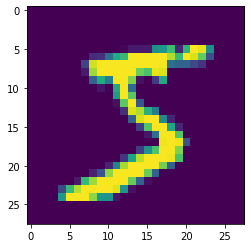

In [14]:
plt.imshow(mnist_train.data[0])

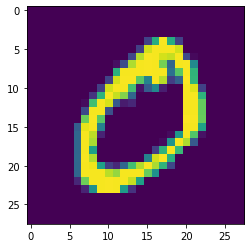

In [15]:
plt.imshow(mnist_train.data[1])

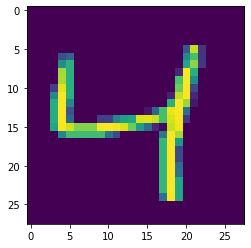

In [16]:
plt.imshow(mnist_train.data[2])

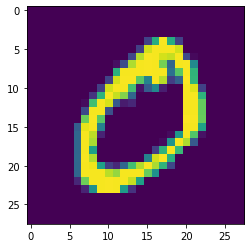

In [7]:
plt.imshow(mnist_train.data[mnist_train.targets == 0][0])

In [28]:
PYTORCH_CUDA_ALLOC_CONF

NameError: name 'PYTORCH_CUDA_ALLOC_CONF' is not defined

In [11]:
!pip install tensorflow

Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
    Running setup.py install for termcolor: started


You should consider upgrading via the 'C:\Users\matsumoto.yuta\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


    Running setup.py install for termcolor: finished with status 'done'


In [13]:
import keras
from keras.datasets import mnist
import numpy as np
from PIL import Image

# 文字画像表示
def ConvertToImg(img):
    return Image.fromarray(np.uint8(img))

# Kerasの関数でデータの読み込み。データをシャッフルして学習データと訓練データに分割
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [24]:
mask = y_train == 8
y_train[mask]

array([8, 8, 8, ..., 8, 8, 8], dtype=uint8)

In [26]:

# MNIST一文字の幅
chr_w = 28
# MNIST一文字の高さ
chr_h = 28
# 表示する文字数
num = 16

# MNISTの文字をPILで１枚の画像に描画する
canvas = Image.new('RGB', (int(chr_w * num/2), int(chr_h * num/2)), (255, 255, 255))

# MNISTの文字を読み込んで描画
i = 0
for y in range( int(num/2) ):
    for x in range( int(num/2) ):
        chrImg = ConvertToImg(x_train[mask][i].reshape(chr_w, chr_h))
        canvas.paste(chrImg, (chr_w*x, chr_h*y))
        i = i + 1

canvas.show()
# 表示した画像をJPEGとして保存
canvas.save('mnist.jpg', 'JPEG', quality=100, optimize=True)